In [6]:
import pickle

In [8]:
with open('ner_train.pkl', 'rb') as f:
    corpus_train = pickle.load(f)

with open('ner_test.pkl', 'rb') as t:
    corpus_test = pickle.load(t)

In [9]:
train_inputs = []
train_targets = []

for sentence_tag_paris in corpus_train:
    tokens = []
    tags = []
    for token, tag in sentence_tag_paris:
        tokens.append(token)
        tags.append(tag)
    train_inputs.append(tokens)
    train_targets.append(tags)

In [22]:
test_inputs = []
test_targets = []

for sentence_tag_paris in corpus_test:
    tokens = []
    tags = []
    for token, tag in sentence_tag_paris:
        tokens.append(token)
        tags.append(tag)
    test_inputs.append(tokens)
    test_targets.append(tags)

In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Bidirectional
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [23]:
#convert sentence to sequence
MAX_VOCAB_SIZE = None

should_lowercase = False #beacuse capitalization might be useful -> dff meanings
word_tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE,
    lower = should_lowercase,
    oov_token='UNK',
    )
#otherwise unknown tokens will be removed and len(input) ≠ len(target)

word_tokenizer.fit_on_texts(train_inputs)
train_inputs_int = word_tokenizer.texts_to_sequences(train_inputs)
test_inputs_int = word_tokenizer.texts_to_sequences(test_inputs)

In [24]:
#get word -> integer mapping
word2idx = word_tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 23299 unique tokens.


In [25]:
def flatten(list_of_lists):
    flattened = [val for sublist in list_of_lists for val in sublist]
    return flattened

In [26]:
all_train_targets = set(flatten(train_targets))
all_train_targets

{'B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O'}

In [27]:
all_test_targets = set(flatten(test_targets))
all_test_targets

{'B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O'}

In [28]:
all_train_targets == all_test_targets

True

In [29]:
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(train_targets)

train_targets_int = tag_tokenizer.texts_to_sequences(train_targets)
test_targets_int = tag_tokenizer.texts_to_sequences(test_targets)

#save for later
train_targets_int_unpadded = train_targets_int
test_targets_int_unpadded = test_targets_int

In [30]:
maxlen_train = max(len(sent) for sent in train_inputs)
maxlen_test = max(len(sent) for sent in test_inputs)
T = max((maxlen_test, maxlen_train))
T

113

In [31]:
train_inputs_int = pad_sequences(train_inputs_int, maxlen=T)
print('Shape of data train tensor:', train_inputs_int.shape)

test_inputs_int = pad_sequences(test_inputs_int, maxlen=T)
print('Shape of data test tensor:', test_inputs_int.shape)

train_targets_int = pad_sequences(train_targets_int, maxlen=T)
print('Shape of train targets tensor:', train_targets_int.shape)

test_targets_int = pad_sequences(test_targets_int, maxlen=T)
print('Shape of test targets tensor:', test_targets_int.shape)

Shape of data train tensor: (12733, 113)
Shape of data test tensor: (2970, 113)
Shape of train targets tensor: (12733, 113)
Shape of test targets tensor: (2970, 113)


In [32]:
K = len(tag_tokenizer.word_index)+1
K

10

In [33]:
D = 32

i = Input(shape = (T,))
x = Embedding(V+1, D, mask_zero=True)(i) 
x = Bidirectional(LSTM(32, return_sequences=True))(x)
x = Dense(K)(x)

model = Model(i,x)

2022-06-23 17:07:30.167809: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [34]:
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer = 'adam',
    metrics = ['accuracy']
    )

In [35]:
r = model.fit(
    train_inputs_int, 
    train_targets_int, 
    epochs=5,
    validation_data=(test_inputs_int, test_targets_int)
    )

Epoch 1/5
398/398 [==============================] - 66s 146ms/step - loss: 0.1007 - accuracy: 0.8382 - val_loss: 0.0657 - val_accuracy: 0.8636
Epoch 2/5
398/398 [==============================] - 54s 136ms/step - loss: 0.0436 - accuracy: 0.8984 - val_loss: 0.0461 - val_accuracy: 0.9049
Epoch 3/5
398/398 [==============================] - 46s 114ms/step - loss: 0.0246 - accuracy: 0.9482 - val_loss: 0.0373 - val_accuracy: 0.9260
Epoch 4/5
398/398 [==============================] - 38s 95ms/step - loss: 0.0130 - accuracy: 0.9754 - val_loss: 0.0315 - val_accuracy: 0.9419
Epoch 5/5
398/398 [==============================] - 45s 112ms/step - loss: 0.0073 - accuracy: 0.9875 - val_loss: 0.0284 - val_accuracy: 0.9483


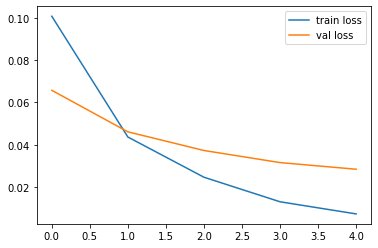

In [36]:
plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'val loss')
plt.legend()
plt.show();

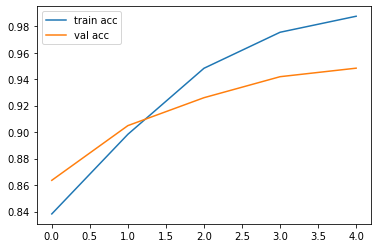

In [37]:
plt.plot(r.history['accuracy'], label = 'train acc')
plt.plot(r.history['val_accuracy'], label = 'val acc')
plt.legend()
plt.show();

In [38]:
# true model acc - above include padding

# len
train_length = []
for sentence in train_inputs:
    train_length.append(len(sentence))

test_length = []
for sentence in test_inputs:
    test_length.append(len(sentence))

In [39]:
train_probs = model.predict(train_inputs_int)
train_pred = []

for prob,length in zip(train_probs, train_length):
    probs_ = prob[-length:]
    preds = np.argmax(probs_, axis = 1)
    train_pred.append(preds)

#flatten
flat_train_pred = flatten(train_pred)
flat_train_targets = flatten(train_targets_int_unpadded)

398/398 [==============================] - 11s 19ms/step


In [40]:
test_probs = model.predict(test_inputs_int)
test_pred = []

for prob,length in zip(test_probs, test_length):
    probs_ = prob[-length:]
    preds = np.argmax(probs_, axis = 1)
    test_pred.append(preds)

#flatten
flat_test_pred = flatten(test_pred)
flat_test_targets = flatten(test_targets_int_unpadded)

93/93 [==============================] - 2s 21ms/step


In [41]:
from sklearn.metrics import accuracy_score, f1_score

print('Train acc: ', accuracy_score(flat_train_targets, flat_train_pred))
print('Test acc: ', accuracy_score(flat_test_targets, flat_test_pred))

print('Train F1-score:', f1_score(flat_train_targets, flat_train_pred, average = 'macro'))
print('Test F1-score:', f1_score(flat_test_targets, flat_test_pred, average = 'macro'))

Train acc:  0.9923502863050739
Test acc:  0.9482850227286145
Train F1-score: 0.9464643537230205
Test F1-score: 0.7801817721240214


In [42]:
from collections import Counter

def most_common(lst):
    data = Counter(lst)
    return data.most_common(1)[0][0]

In [43]:
token2tags = {k: [] for k,v in word2idx.items()}

#remove UNK token
del token2tags['UNK']

for tokens, tags in zip(train_inputs, train_targets):
    for token, tag in zip(tokens, tags):
        if should_lowercase:
            token = token.lower()
        if token in token2tags:
            token2tags[token].append(tag)
            
token2tag = {k: most_common(v) for k,v in token2tags.items()}

In [44]:
train_pred = []

for sentences in train_inputs:
    pred = []
    for token in sentences:
        if should_lowercase:
            token = token.lower()
        predicted_tag = token2tag[token]
        pred.append(predicted_tag)
    train_pred.append(pred)

flat_train_pred = flatten(train_pred)
flat_train_targets = flatten(train_targets)

test_pred = []

for sentences in test_inputs:
    pred = []
    for token in sentences:
        predicted_tag = token2tag.get(token, 'INCORRECT')
        pred.append(predicted_tag)
    test_pred.append(pred)

flat_test_pred = flatten(test_pred)
flat_test_targets = flatten(test_targets)

In [45]:
print('Train acc: ', accuracy_score(flat_train_targets, flat_train_pred))
print('Test acc: ', accuracy_score(flat_test_targets, flat_test_pred))

print('Train F1-score:', f1_score(flat_train_targets, flat_train_pred, average = 'macro'))
print('Test F1-score:', f1_score(flat_test_targets, flat_test_pred, average = 'macro'))

Train acc:  0.974769365357086
Test acc:  0.8881673455733318
Train F1-score: 0.8549353965547479
Test F1-score: 0.6381158268902334


worse f1 -> our model make sense